In [48]:
import pandas as pd
import gurobipy as gp
import numpy as np
from gurobipy import GRB

# cd C:\Users\julia\OneDrive\DTU\course\S2\46755 - Renewables in Electricity Markets\Assignment1 - git

################################################################################
# Creation of Conventionnal Generation Units
################################################################################

from scripts.generationUnits import GenerationUnits

# Parameter units
generationUnits_parameters = pd.read_csv("../inputs/gen_parameters.csv", sep=";")

nodes = generationUnits_parameters["Node"].values
costs = generationUnits_parameters["Ci"].values
pmax = generationUnits_parameters["Pmax"].values
pmin = generationUnits_parameters["Pmin"].values
Csu = generationUnits_parameters["Csu"].values  # Start-up cost
Uini = generationUnits_parameters["Uini"].values  # Initial state (1 if on, 0 else)
ramp_up = generationUnits_parameters["RU"].values  # Maximum augmentation of production (ramp-up)
ramp_down = generationUnits_parameters["RD"].values  # Maximum decrease of production (ramp-up)
prod_init = generationUnits_parameters["Pini"].values  # Initial production
up_reserve = generationUnits_parameters["R+"].values # Up reserve capacity 
down_reserve = generationUnits_parameters["R-"].values # Down reserve capacity
up_reserve_offer = generationUnits_parameters["Cu"].values #Up reserve offer price of the generating unit
down_reserve_offer = generationUnits_parameters["Cd"].values #Down reserve offer price of the generating unit

generation_units = GenerationUnits()
nbUnitsConventionnal = generationUnits_parameters.shape[0]
for unit_id in range(nbUnitsConventionnal):
    generation_units.add_unit(
        unit_id=unit_id,
        node_id=nodes[unit_id],
        unit_type="conventionnal",
        cost=costs[unit_id],
        pmax=pmax[unit_id],
        pmin=pmin[unit_id],
        availability=[1] * 24,
        ramp_up=ramp_up[unit_id],
        ramp_down=ramp_down[unit_id],
        prod_init=prod_init[unit_id],
        up_reserve=up_reserve[unit_id],
        down_reserve=down_reserve[unit_id],
        up_reserve_offer=up_reserve_offer[unit_id],
        down_reserve_offer=down_reserve_offer[unit_id],
    )

################################################################################
# Adding of the Wind Generation Units
################################################################################

wind_parameters = pd.read_csv("../inputs/wind_parameters.csv", index_col="Unit", sep=";")
nodes = wind_parameters["Node"].values
pmax = wind_parameters["Pmax"].values
pmin = wind_parameters["Pmin"].values
costs = wind_parameters["Ci"].values

scenario = "V1"  # scenario : from V1 to V100

nbUnitsWind = wind_parameters.shape[0]
nbUnits = nbUnitsConventionnal + nbUnitsWind
for unit_id in range(nbUnitsWind):

    availability = pd.read_csv(f"../inputs/data/scen_zoneW{unit_id}.csv", sep=",")[
        scenario
    ].values.tolist()

    generation_units.add_unit(
        unit_id=unit_id + nbUnitsConventionnal,
        node_id=nodes[unit_id],
        unit_type="wind_turbine",
        cost=costs[unit_id],
        pmax=pmax[unit_id],
        pmin=pmin[unit_id],
        availability=availability[:24],
        ramp_up=10000,  # big M, for no constraint on rampu_up
        ramp_down=0,
        prod_init=0,
        up_reserve=0,
        down_reserve=0,
        up_reserve_offer=0,
        down_reserve_offer=0,
    )

#generation_units.export_to_json()

################################################################################
# Creation of Loads Units
################################################################################

from scripts.loadUnits import LoadUnits

# parameter load
total_needed_demand = pd.read_csv("../inputs/load_profile.csv", sep=";")[
    "total_demand"
].values
nbHour = total_needed_demand.shape[0]

load_location = pd.read_csv(
    "../inputs/load_location.csv", index_col="load_number", sep=";"
)
nodes = load_location["node"].values
load_percentage = load_location["load_percentage"].values

load_units = LoadUnits()
nbLoadUnits = load_location.shape[0]
for unit_id in range(nbLoadUnits):
    load_units.add_unit(
        load_id=unit_id,
        node_id=nodes[unit_id],
        bid_price=30,
        load_percentage=load_percentage[unit_id],
        total_needed_demand=total_needed_demand,
    )

#load_units.export_to_json()


################################################################################
# Adding of the battery
################################################################################
efficiency = np.sqrt(0.937)
min_SoC = 0  # minimum of the battery capacity (called here Sate Of Charge but not in %)
max_SoC = 600  # MWh maximum of state of charge = battery capacity
value_init = max_SoC / 2 #Start with 50%
P_max = 150  # MW
delta_t = 1  # hour

################################################################################
# Model
################################################################################

from scripts.plot_results import plot_results

def step2_multiple_hours(show_plots:bool=False):
    m = gp.Model()

    # Variables
    production =  {t: {g: m.addVar(
        lb=0, 
        ub=generation_units.units[g]["PMAX"] * generation_units.units[g]["Availability"][t],  # generation unitsPhave a _max
        name=f'production of generator {g} at time {t}',
        vtype=GRB.CONTINUOUS
        ) 
        for g in range(nbUnits)} for t in range(nbHour)}
  

    demand_supplied = {t: {l: m.addVar(
        lb=0, 
        ub=load_units.units[l]["Needed demand"][t],     # Cannot supply more than necessary
        name=f'Supplied demand to load {l} at time {t}',
        vtype=GRB.CONTINUOUS        
        )
        for l in range(nbLoadUnits)} for t in range(nbHour)
    }
    state_of_charge = m.addMVar(
        shape=(nbHour,),
        lb=min_SoC,
        ub=max_SoC,
        name=f"state_of_charge",
        vtype=GRB.CONTINUOUS,
    )
    power_injected = m.addMVar(
        shape=(nbHour,),
        lb=0,
        ub=P_max,
        name=f"power_injected",
        vtype=GRB.CONTINUOUS,
    )
    power_drawn = m.addMVar(
        shape=(nbHour,),
        lb=0,
        ub=P_max,
        name=f"power_drawn",
        vtype=GRB.CONTINUOUS,
    )

    # Objective function
    objective = gp.quicksum(
        demand_supplied[t][l] * load_units.units[l]["Bid price"]
        for t in range(nbHour)
        for l in range(nbLoadUnits)
    )  - gp.quicksum(
        production[t][g] * generation_units.units[g]["Cost"]
        for t in range(nbHour)
        for g in range(nbUnits)
    ) 
    m.setObjective(objective, GRB.MAXIMIZE)

    # Constraints

    # Supplied demand match generation
    balance_constraint = [
        m.addConstr(
            sum(demand_supplied[t][l] for l in range(nbLoadUnits)) + power_drawn[t]
            - gp.quicksum(production[t][g] for g in range(nbUnits)) - power_injected[t] 
            == 0,
            name=f"GenerationBalance_{t}",
        )
        for t in range(nbHour)
    ]

    # Ramp-up and ramp-down constraint
    ramp_up_constraint = []
    ramp_down_constraint = []
    for g in range(nbUnits):
        for t in range(nbHour):
            if t == 0:  # Apply the special condition for t=0
                ramp_up_constraint.append(
                    m.addConstr(
                        production[t][g]
                        <= generation_units.units[g]["Initial production"]
                        + generation_units.units[g]["Ramp up"],
                    )
                )
                ramp_down_constraint.append(
                    m.addConstr(
                        production[t][g]
                        >= generation_units.units[g]["Initial production"]
                        - generation_units.units[g]["Ramp down"],
                    )
                )
            else:  # Apply the regular ramp-down constraint for t>0
                ramp_up_constraint.append(
                    m.addConstr(
                        production[t][g]
                        <= production[t-1][g] + generation_units.units[g]["Ramp up"],
                    )
                )
                ramp_down_constraint.append(
                    m.addConstr(
                        production[t][g]
                        >= production[t-1][g] - generation_units.units[g]["Ramp down"],
                    )
                )

    # Battery constraints
    actualise_SoC = [
        m.addConstr(
            state_of_charge[t]
            == state_of_charge[t-1] + (- power_injected[t]/efficiency  + power_drawn[t]*efficiency)* delta_t
        )
        for t in range(1,nbHour)
    ]
    m.addConstr(state_of_charge[0] == value_init )# - (power_injected[0]/efficiency  - power_drawn[0]*efficiency))
    m.addConstr(value_init - state_of_charge[-1] <= 0)

    m.optimize()

    ################################################################################
    # Results
    ################################################################################

    clearing_price = [balance_constraint[t].Pi for t in range(nbHour)]
    clearing_price_values = [
        price_item.flatten()[0] for price_item in clearing_price
    ]  # remove the array values

    profit = [
        [
            production[t][g].X * (clearing_price[t] - generation_units.units[g]["Cost"])
            for g in range(nbUnits)
        ]
        for t in range(nbHour)
    ]

    demand_unsatisfied = [
        total_needed_demand[t] - np.sum(demand_supplied[t][l].X for l in range(nbLoadUnits))
        for t in range(nbHour)
    ]

    print(f"Optimal objective value: {round(m.objVal)} $")
    # for t in range(nbHour):
    #     print('\n')
    #     for g in range(nbUnits):
    #         print(
    #             f"p_{g+1} for hour {t+1}: production: {round(production[t][g].X,2)} MW, profit: {round(profit[t][g],2)} $"
    #         )
    #     print(f"clearing price for hour {t+1}:", round(clearing_price_values[t],2))
    # print("clearing price:", clearing_price_values,2)
    # print("demand unsatisfied:", demand_unsatisfied,2)
    # print("SoC:", state_of_charge.X)

    results = pd.DataFrame()
    results["Hour"] = np.arange(nbHour)
    for g in range(nbUnits):
        results[f"PU production {g+1} (GW)"] = [production[t][g].X for t in range(nbHour)]
        results[f"PU profit {g+1} ($)"] = [profit[t][g] for t in range(nbHour)]
    results["Clearing price"] = clearing_price_values
    results["Demand"] = total_needed_demand
    results["Demand satisfied"] = total_needed_demand - demand_unsatisfied
    results["Demand unsatisfied"] = demand_unsatisfied
    results["Battery production"] = - power_injected.X + power_drawn.X
    results["State of charge"] = state_of_charge.X / max_SoC
    results["Battery profit"] = -results["Clearing price"] * results["Battery production"]

    if show_plots:
        plot_results(nbUnits=nbUnits, results=results)

    return m, results

m, results = step2_multiple_hours(show_plots=False)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 913 rows, 912 columns and 2674 nonzeros
Model fingerprint: 0xb73f6b35
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 3e+01]
  Bounds range     [4e+01, 6e+02]
  RHS range        [3e+01, 1e+04]
Presolve removed 568 rows and 412 columns
Presolve time: 0.02s
Presolved: 345 rows, 660 columns, 1325 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5819927e+06   5.739182e+03   0.000000e+00      0s
     177    1.3740218e+06   0.000000e+00   0.000000e+00      0s

Solved in 177 iterations and 0.03 seconds (0.00 work units)
Optimal objective  1.374021781e+06
Optimal objective value: 1374022 $


C:\Users\utilisateur\AppData\Local\Temp\ipykernel_13672\3247078306.py:271: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_needed_demand[t] - np.sum(demand_supplied[t][l].X for l in range(nbLoadUnits))


In [41]:
import matplotlib.pyplot as plt 
results.head()

,Hour,PU production 1 (GW),PU profit 1 ($),PU production 2 (GW),PU profit 2 ($),PU production 3 (GW),PU profit 3 ($),PU production 4 (GW),PU profit 4 ($),PU production 5 (GW),...,PU profit 17 ($),PU production 18 (GW),PU profit 18 ($),Clearing price,Demand,Demand satisfied,Demand unsatisfied,Battery production,State of charge,Battery profit
0,0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,243.288005,109.767393,660.799706,6.02000,1775.835,1775.835,-2.273737e-13,-150.000000,0.500000,903.000000
1,1,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,403.816633,109.767393,705.229142,6.42476,1669.815,1669.815,0.000000e+00,-23.852401,0.458931,153.245948
2,2,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,520.546590,113.564435,683.657896,6.02000,1590.300,1590.300,0.000000e+00,0.000000,0.458931,-0.000000
3,3,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,544.417265,113.564435,683.657896,6.02000,1563.795,1563.795,-2.273737e-13,133.686875,0.674610,-804.794986
4,4,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,656.304597,113.564435,683.657896,6.02000,1563.795,1563.795,-2.273737e-13,51.690587,0.758003,-311.177335


In [42]:
results.columns

Index(['Hour', 'PU production 1 (GW)', 'PU profit 1 ($)',
       'PU production 2 (GW)', 'PU profit 2 ($)', 'PU production 3 (GW)',
       'PU profit 3 ($)', 'PU production 4 (GW)', 'PU profit 4 ($)',
       'PU production 5 (GW)', 'PU profit 5 ($)', 'PU production 6 (GW)',
       'PU profit 6 ($)', 'PU production 7 (GW)', 'PU profit 7 ($)',
       'PU production 8 (GW)', 'PU profit 8 ($)', 'PU production 9 (GW)',
       'PU profit 9 ($)', 'PU production 10 (GW)', 'PU profit 10 ($)',
       'PU production 11 (GW)', 'PU profit 11 ($)', 'PU production 12 (GW)',
       'PU profit 12 ($)', 'PU production 13 (GW)', 'PU profit 13 ($)',
       'PU production 14 (GW)', 'PU profit 14 ($)', 'PU production 15 (GW)',
       'PU profit 15 ($)', 'PU production 16 (GW)', 'PU profit 16 ($)',
       'PU production 17 (GW)', 'PU profit 17 ($)', 'PU production 18 (GW)',
       'PU profit 18 ($)', 'Clearing price', 'Demand', 'Demand satisfied',
       'Demand unsatisfied', 'Battery production', 'State of 

PU production 1 (GW)


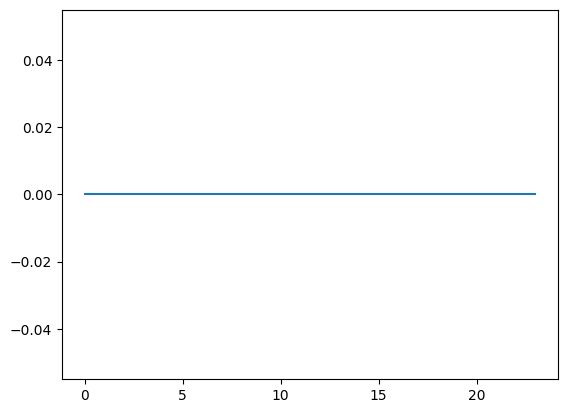

PU production 2 (GW)


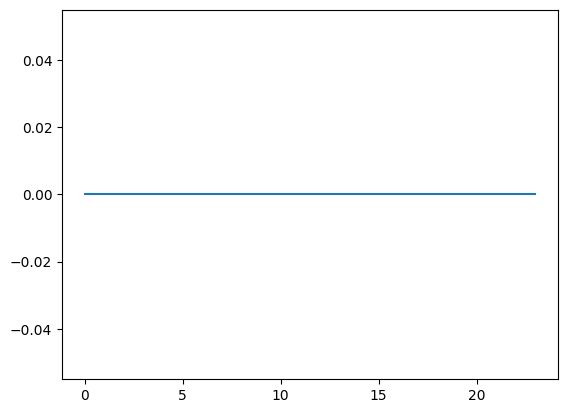

PU production 3 (GW)


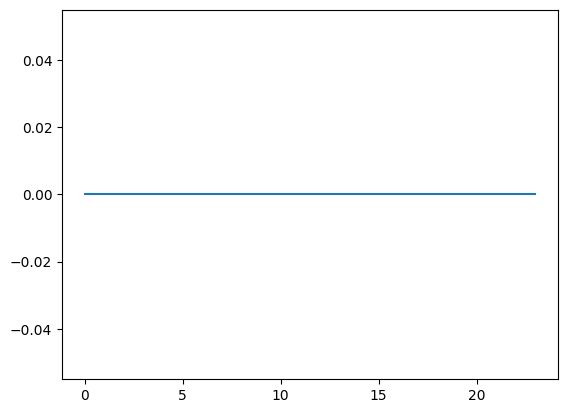

PU production 4 (GW)


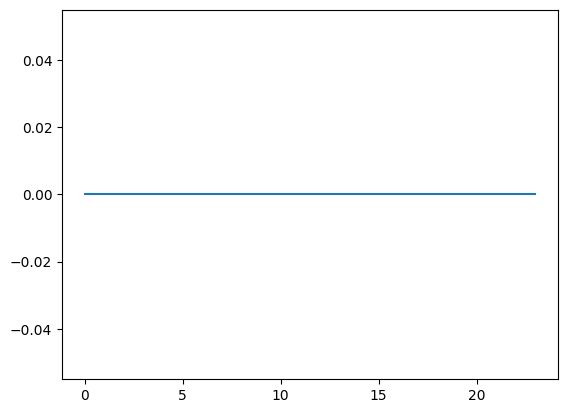

PU production 5 (GW)


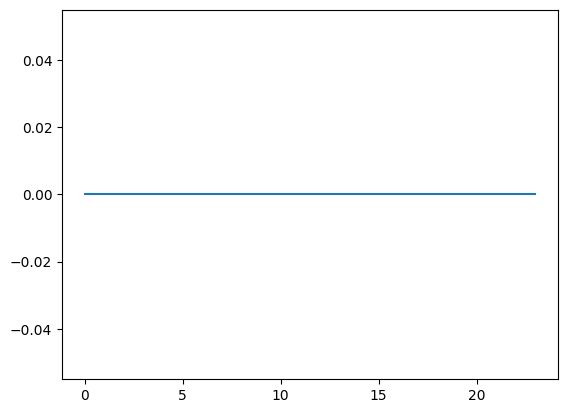

PU production 6 (GW)


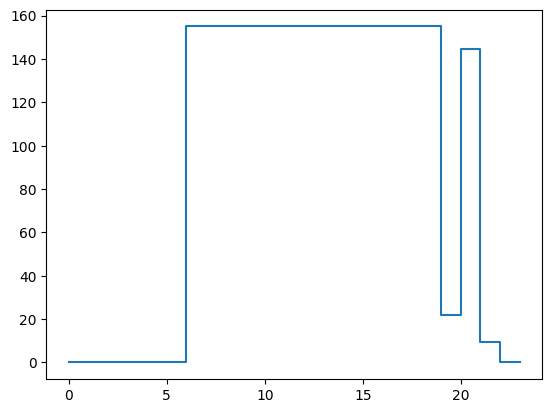

PU production 7 (GW)


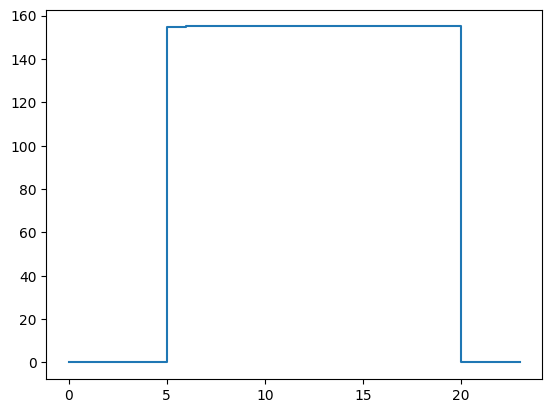

PU production 8 (GW)


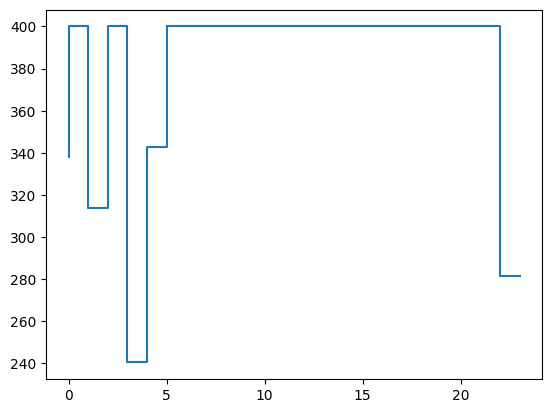

PU production 9 (GW)


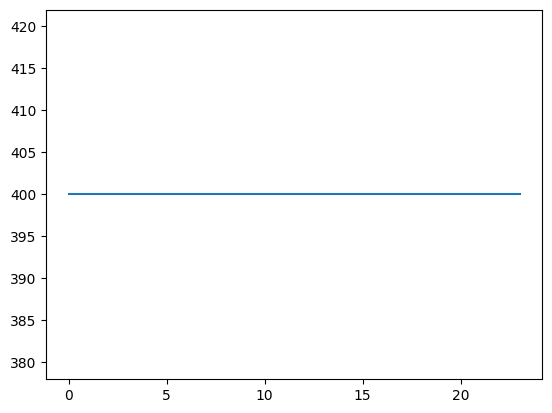

PU production 10 (GW)


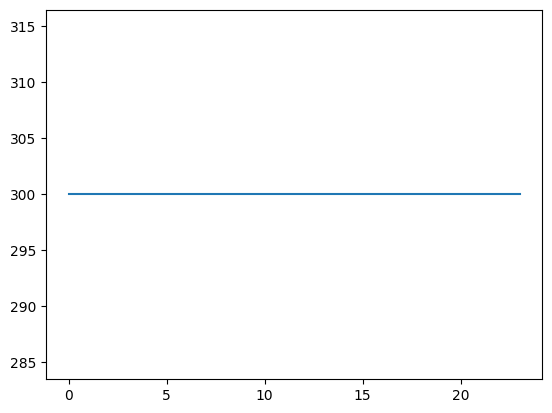

PU production 11 (GW)


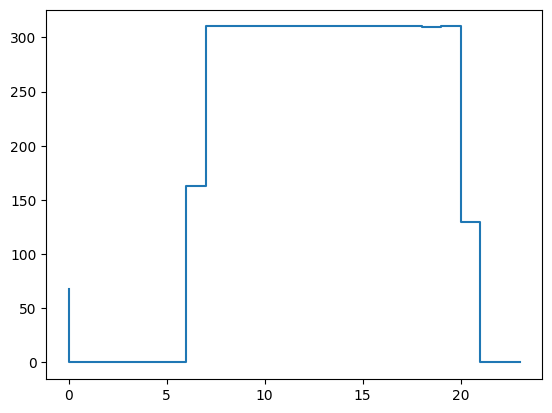

PU production 12 (GW)


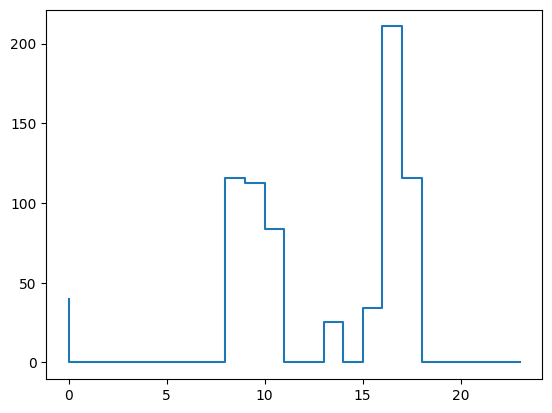

PU production 13 (GW)


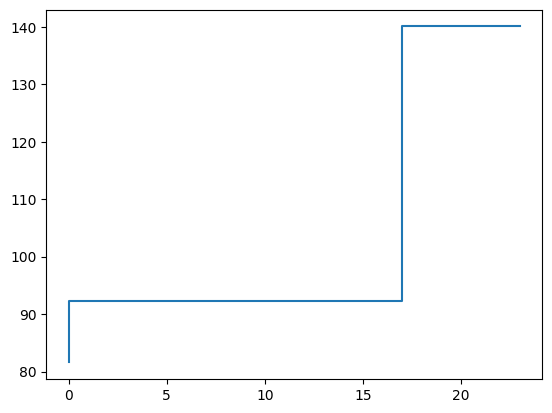

PU production 14 (GW)


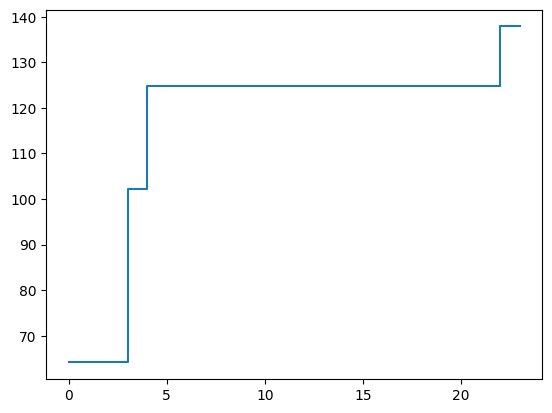

PU production 15 (GW)


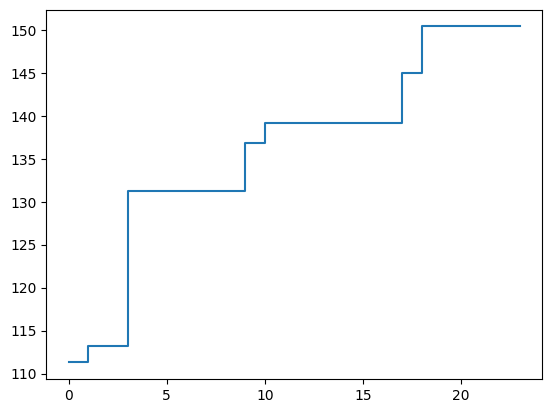

PU production 16 (GW)


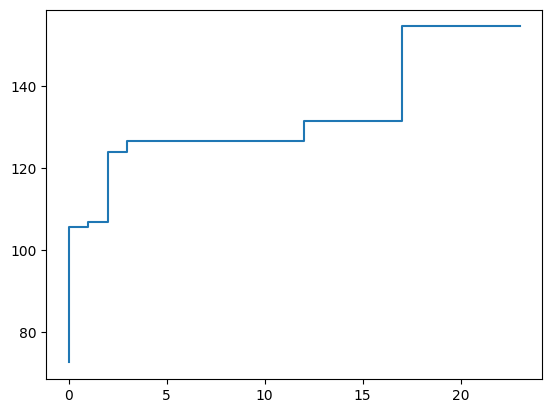

PU production 17 (GW)


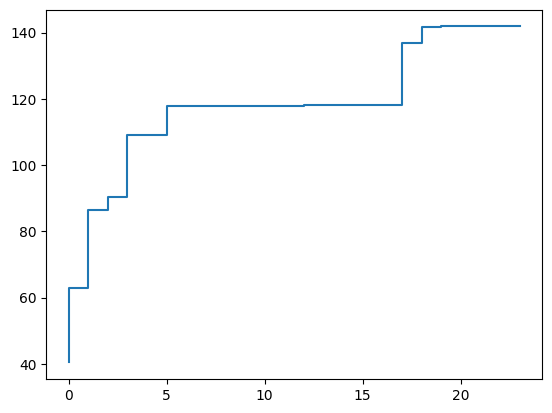

PU production 18 (GW)


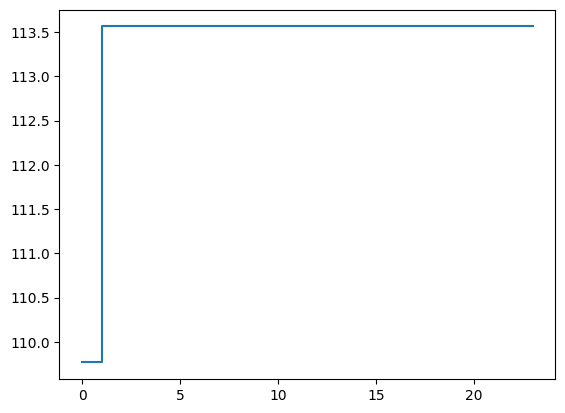

In [59]:
for j in range(1,12+6+1):
    name = f"PU production {j} (GW)"
    print(name)
    plt.figure()
    plt.step(x=results['Hour'], y=results[name],where='pre')
    plt.show()